# Link Prediction w/ n2v

In [1]:
# !pip install arxiv

You can install the arxiv package in Python with the following command:  
`pip install arxiv`  
or follow the instructions here : https://pypi.org/project/arxiv/  

## What is Link Prediction?



## Cold Start Problem in Recommendation Systems

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec as n2v
from node2vec.edges import HadamardEmbedder

In [3]:
# constants
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

# Fetch Data

We want to hit th Arxiv API to gather some information about the latest research papers based on the queries we've identified above. This will allow us to then create a network from this research paper data and then we can try to predict links on that network. For the purposes of this article, I will search for a maximum of 1000 results per query, but you don't have to set yourself to the same constraints. The Arxiv API allows users to hit up to 300,000 results per query. The function outlined below will generate a CSV fetching the following information :   
```'title', 'date', 'article_id', 'url', 'main_topic', 'all_topics', 'authors', 'year'```   
You are able to fetch more information like the `links, summary, article` but I decided not to since those features won't really be used for the purposes of this analysis and tutorial.

For reference to the Arxiv API, you can find their detailed documentation here : https://arxiv.org/help/api/user-manual

In [4]:
def search_arxiv(queries, max_results = 1000):
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d

In [5]:
%%time
research_df = search_arxiv(
    queries = queries,
    max_results = 500
)
research_df.shape

CPU times: user 4.25 s, sys: 294 ms, total: 4.55 s
Wall time: 1min 42s


(2832, 8)

If you're having trouble querying the data, for reproducibility purposes, the CSV I used for the analysis conducted in this article was uploaded to my GitHub which you can find here. https://github.com/vatsal220/medium_articles/blob/main/link_prediction/data/arxiv_data.csv

## Generate Network

Now that we've fetched the data using the Arxiv API, we can generate a network. The network will have the following structure, nodes will be the article_ids and the edges will be all topics connecting a pair of articles. For example, article_id 1 with the following topics `astro-physics, and stats` can be connected to article_id 10 with the topic `stats` and article_id 7 with the topics `astro-physics, math`. This will be a multi-edge network where each edge will hold a weight of 1.

In [8]:
def generate_network(df, node_col = 'article_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

In [6]:
all_tp = research_df.explode('all_topics').copy()

In [9]:
%%time
tp_nx = generate_network(
    all_tp, 
    node_col = 'article_id', 
    edge_col = 'all_topics'
)

CPU times: user 3.27 s, sys: 126 ms, total: 3.4 s
Wall time: 3.6 s


In [10]:
print(nx.info(tp_nx))

Name: 
Type: Graph
Number of nodes: 2431
Number of edges: 495309
Average degree: 407.4940


In [11]:
%%time
research_nx = generate_network(
    research_df, 
    node_col = 'article_id', 
    edge_col = 'main_topic'
)

CPU times: user 1.9 s, sys: 49.2 ms, total: 1.95 s
Wall time: 1.98 s


In [12]:
print(nx.info(research_nx))

Name: 
Type: Graph
Number of nodes: 2431
Number of edges: 193322
Average degree: 159.0473


In [24]:
%%time 
adj, research_network = generate_network(
    research_df, 
    node_col = 'article_id', 
    edge_col = 'main_topic'
)

CPU times: user 541 ms, sys: 222 ms, total: 763 ms
Wall time: 817 ms


In [25]:
print(nx.info(research_network))

Name: 
Type: Graph
Number of nodes: 4513
Number of edges: 4513
Average degree:   2.0000


In [113]:
test = pd.DataFrame.from_dict({
    'a1' : [0,0,0,1,2,1,3,4,5,6,7],
#     'a2' : [0,0,0,1,2,3,4,5,6,7],
    'tp' : ['cs', 'mth', 'phy', 'cs', 'cl', 'eng', 'mth', 'eng', 'phy', 'cl', 'cl'],
#     'tp2': ['cs', 'mth', 'phy', 'cs', 'cl', 'mth', 'eng', 'phy', 'cl', 'cl']
}, orient = 'columns')

In [114]:
test

,a1,tp
0,0,cs
1,0,mth
2,0,phy
3,1,cs
4,2,cl
5,1,eng
6,3,mth
7,4,eng
8,5,phy
9,6,cl


In [138]:
test_edge_dct = {}
for i,g in test.groupby('a1'):
    topics = g['tp'].unique()
    edge_df = test[(test['a1'] != i) & (test['tp'].isin(topics))]
    print(edge_df)
    edges = list(edge_df['a1'].unique())
    print(i, edges)
    break

   a1   tp
3   1   cs
6   3  mth
8   5  phy
0 [1, 3, 5]


In [118]:
m = np.array([
    [0,1,0,1,0,1,0,0],
    [1,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,1,1],
    [1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,1],
    [0,0,1,0,0,0,1,0]
])

In [123]:
edge_dct = {
    0 : [1, 3, 5],
    1 : [0, 4],
    2 : [6,7],
    3 : [0],
    4 : [1],
    5 : [0],
    6 : [2,7],
    7 : [2,6]
}

In [140]:
g3 = generate_network(test, node_col = 'a1', edge_col = 'tp')

In [141]:
print(nx.info(g3))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 7
Average degree:   1.7500


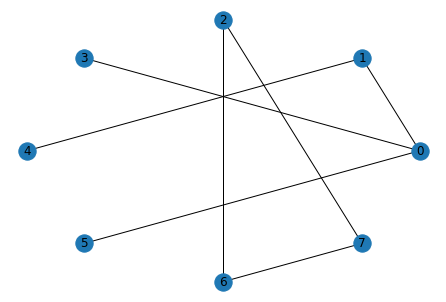

In [142]:
nx.draw_circular(g3, with_labels = True)

In [124]:
g2 = nx.Graph(edge_dct)

In [125]:
print(nx.info(g2))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 7
Average degree:   1.7500


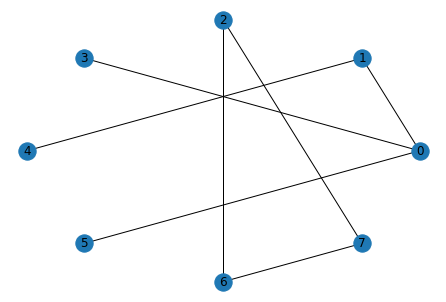

In [126]:
nx.draw_circular(g2, with_labels = True)

In [120]:
tg = nx.convert_matrix.from_numpy_array(m)
print(nx.info(tg))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 7
Average degree:   1.7500


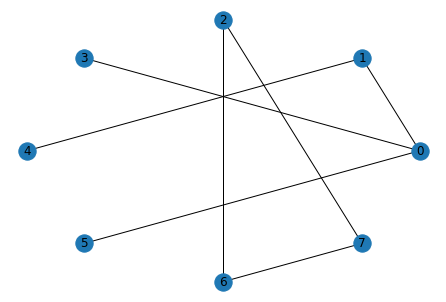

In [122]:
nx.draw_circular(tg, with_labels = True)

In [97]:
from itertools import product

In [104]:
users = test.a1.nunique()
mat = np.zeros([users, users])

In [105]:
mat

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [106]:
for i,g in test.groupby('tp'):
    users1 = test['a1'].unique()
    prod_comb = [(x,y) for (x,y) in product(users1, users1) if x>y]
    if len(prod_comb) >= 1:
        for comb in prod_comb:
            mat[comb[0]][comb[1]] += 1

In [107]:
mat

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0.],
       [5., 5., 5., 5., 0., 0., 0., 0.],
       [5., 5., 5., 5., 5., 0., 0., 0.],
       [5., 5., 5., 5., 5., 5., 0., 0.],
       [5., 5., 5., 5., 5., 5., 5., 0.]])

In [109]:
gg = nx.convert_matrix.from_numpy_array(mat)

In [110]:
print(nx.info(gg))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 28
Average degree:   7.0000


In [76]:
test.pivot_table(
    index = 'a1',
    columns = 'a2',
    values = 'tp',
    aggfunc = 'count'
)

a2,0,1,2,3,4,5,6,7
a1,,,,,,,,
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [26]:
research_df

,title,date,article_id,url,main_topic,all_topics,authors,year
0,Review of automated time series forecasting pi...,2022-02-03 17:26:27+00:00,0,http://arxiv.org/pdf/2202.01712v1,cs.LG,[cs.LG],"[Stefan Meisenbacher, Marian Turowski, Kaleb P...",2022
1,Hubble Asteroid Hunter: I. Identifying asteroi...,2022-02-01 06:56:20+00:00,1,http://arxiv.org/pdf/2202.00246v1,astro-ph.EP,"[astro-ph.EP, astro-ph.IM]","[Sandor Kruk, Pablo García Martín, Marcel Pope...",2022
2,NAS-Bench-Suite: NAS Evaluation is (Now) Surpr...,2022-01-31 18:02:09+00:00,2,http://arxiv.org/pdf/2201.13396v2,cs.LG,"[cs.LG, cs.AI, stat.ML]","[Yash Mehta, Colin White, Arber Zela, Arjun Kr...",2022
3,Online AutoML: An adaptive AutoML framework fo...,2022-01-24 15:37:20+00:00,3,http://arxiv.org/pdf/2201.09750v1,cs.LG,"[cs.LG, cs.AI]","[Bilge Celik, Prabhant Singh, Joaquin Vanschoren]",2022
4,Automated Reinforcement Learning (AutoRL): A S...,2022-01-11 12:41:43+00:00,4,http://arxiv.org/pdf/2201.03916v1,cs.LG,[cs.LG],"[Jack Parker-Holder, Raghu Rajan, Xingyou Song...",2022
...,...,...,...,...,...,...,...,...
5327,Deep Impulse Responses: Estimating and Paramet...,2022-02-07 18:57:23+00:00,4508,http://arxiv.org/pdf/2202.03416v1,cs.SD,"[cs.SD, cs.LG, eess.AS]","[Alexander Richard, Peter Dodds, Vamsi Krishna...",2022
5328,PopNet: Real-Time Population-Level Disease Pre...,2022-02-07 18:55:46+00:00,4509,http://arxiv.org/pdf/2202.03415v1,cs.SI,[cs.SI],"[Junyi Gao, Cao Xiao, Lucas M. Glass, Jimeng Sun]",2022
5329,Investigating the fidelity of explainable arti...,2022-02-07 18:47:15+00:00,4510,http://arxiv.org/pdf/2202.03407v1,physics.geo-ph,"[physics.geo-ph, cs.AI, cs.LG]","[Antonios Mamalakis, Elizabeth A. Barnes, Imme...",2022
5330,Dependence model assessment and selection with...,2022-02-07 18:44:39+00:00,4511,http://arxiv.org/pdf/2202.03406v1,stat.ML,"[stat.ML, cs.LG, q-fin.CP, q-fin.RM, stat.AP, ...","[Marius Hofert, Avinash Prasad, Mu Zhu]",2022


In [20]:
adj

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Node2Vec

This component will cover running node2vec on the graph generated above and creating the associated node embeddings for that network. These embeddings will play a crucial role coming up as they're the main features necessary for building a link prediction model.

In [ ]:
%time g_emb = n2v(research_network, dimensions=8)

In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [ ]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

In [ ]:
input_node = '1'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

## Generate Embeddings DataFrame

HammardEmbedder is a built in function in the Node2Vec module which will map each edge in the graph to a 2 dimensional vector.

In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=mdl.wv)

In [ ]:
x=[1,2]
edges_embs[str(x[0]),str(x[1])]

In [ ]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in research_network.nodes()],
        index = research_network.nodes
    )
)

In [ ]:
emb_df.head()

## Recommendations w/ Distance Measures

Now that we have a embedding vector representing each node in the network, we can then use distance measures like cosine similarity, euclidean distance, manhattan distance, etc. to measure the amount of distance between nodes. The assumption that we're making by using these distance measures is that nodes in close proximity with each other should also have an edge connecting each other. This is a good assumption to make as node2vec tries to preserve the initial structure of the original input graph. Now we can essentially write out code to measure similarity levels between two vectors using cosine similarity (or a different distance measure) and identify pairs of nodes which don't currently have an edge between them but do have a large similarity should create an edge between them. This interpretation can be different for multi / weighted / directed graphs. Pick and use a similarity measure appropriate to the network and problem you're trying to solve. Also be aware that different measures have different interperations, for this problem you want to pick maximal cosine similarity scores whereas if you were to use something like euclidean distance, you would want to pick the minimal distance between two vectors.

On a side note, I do want to mention that the curse of dimensionality is rampant when solving these types of problems. It's especially problematic when using euclidean distance in particular to measure the distance between vectors in higher dimensions. The term higher dimensions is broad and open to interpretation, the threshold for a dimension to be "high" is not strictly defined and varies from problem to problem. Without going to deep into the mathematics behind things, euclidean distance is not a good measure to use for sparse or high dimensional vectors. You can reference this post on stack exchange which outlines the mathematical reasoning as to why this is the case. 

- https://stats.stackexchange.com/questions/29627/euclidean-distance-is-usually-not-good-for-sparse-data-and-more-general-case
- https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions

For more on the curse of dimensionality, refer to this [paper](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) by the Computer Science department from the University of Washington.

In [ ]:
def predict_links(G, df, article_id, N):
    '''
    This function will predict the top N links a node (article_id) should be connected with
    which it is not already connected with in G.
    
    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        article_id (Integer) : The article you're interested 
        N (Integer) : The number of recommended links you want to return
        
    returns:
        This function will return a list of nodes the input node should be connected with.
    '''
    
    # separate target article with all others
    all_nodes = G.nodes()
    other_nodes = [n for n in G.adj[article_id] if n not in all_nodes]
    
    article = df[df.index == article_id]
    other_articles = df[df.index.isin(other_nodes)]
    
    # get similarity of current reader and all other readers
    sim = cosine_similarity(article, other_articles)[0].tolist()
    idx = other_articles.index.tolist()
    
    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)
    
    similar_articles = idx_sim[:N]
    articles = [art[0] for art in similar_articles]
    return articles

In [ ]:
predict_links(G = research_network, df = emb_df, article_id = 1, N = 10)

In [ ]:
print(nx.info(research_network))

In [47]:
research_network.has_edge(,100)

False

In [60]:
all_nodes = research_network.nodes()

In [72]:
[n for n in research_network.adj[569] if n not in all_nodes]

[]

In [76]:
[len(research_network.adj[a]) for a in range(0, 570) if len(research_network.adj[a]) != 569]

[]

## Modelling Based Recommendations

## Train Model

In [ ]:
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

## Model Performance

## Generate Predictions

---

In [48]:
g = nx.convert_matrix.from_numpy_array(arr, create_using = nx.DiGraph)

In [49]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 2
Number of edges: 4
Average in degree:   2.0000
Average out degree:   2.0000


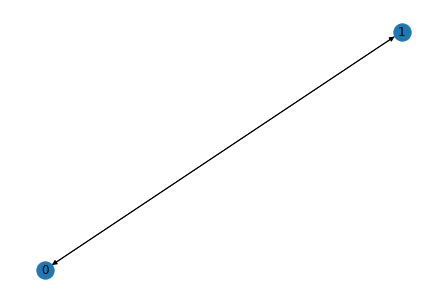

In [50]:
nx.draw(g, with_labels = True)

In [51]:
mat1 = np.array([[0,2,3,0], [2,0,1,1], [3,1,0,0], [0,1,0,0]])
mat2 = np.array([[0,4,5,3], [4,0,1,2], [5,1,0,0], [3,2,0,0]])

In [52]:
mat1@mat2

array([[23,  3,  2,  4],
       [ 8, 11, 10,  6],
       [ 4, 12, 16, 11],
       [ 4,  0,  1,  2]])

In [53]:
mat1.dot(mat2)

array([[23,  3,  2,  4],
       [ 8, 11, 10,  6],
       [ 4, 12, 16, 11],
       [ 4,  0,  1,  2]])

In [54]:
mat1*mat2

array([[ 0,  8, 15,  0],
       [ 8,  0,  1,  2],
       [15,  1,  0,  0],
       [ 0,  2,  0,  0]])

In [55]:
mat1 = np.array([[0,2], [2,0]])
mat2 = np.array([[0,4], [4,0]])

In [56]:
mat1@mat2

array([[8, 0],
       [0, 8]])

In [57]:
mat1*mat2

array([[0, 8],
       [8, 0]])

In [101]:
m_org = np.array(
    [
        [1,4,5,6,8,7,6,5,4,2,3,5],
        [2,3,4,6,2,1,4,4,6,3,2,1],
        [0,1,2,5,3,5,6,4,3,2,6,2],
        [0,7,5,7,2,3,4,5,6,4,2,1],
        [0,1,2,5,3,5,6,4,3,2,6,2],
        [0,1,2,5,3,5,6,4,3,2,6,2],
        [1,4,5,6,8,7,6,5,4,2,3,5],
        [0,1,2,5,3,5,6,4,3,2,6,2]
    ]
)

def create_subarray(arr, r_idx, c_idx):
    try:
        return arr[np.ix_(r_idx, c_idx)]
    except:
        raise IndexError("Index is out of bounds")

s1 = [1,4,6]
create_subarray(m_org, s1, s1)

array([[3, 2, 4],
       [1, 3, 6],
       [4, 8, 6]])

In [95]:
s1 = [1,4,6]

In [96]:
m_org[np.asarray(s1)[:, None], s1]

array([[3, 2, 4],
       [1, 3, 6],
       [4, 8, 6]])